This is a quick prototype of a discrete normalizing flow built with pzflow.

In [1]:
import jax.numpy as np
from jax import random
from jax.experimental.optimizers import adam
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple
from pzflow.bijectors import Bijector, InitFunction, ForwardFunction, InverseFunction, Bijector_Info, StandardScaler, RollingSplineCoupling, Chain
from pzflow.distributions import Uniform
from pzflow import Flow

In [2]:
# Let's generate some discrete 2D data

N = int(1e5) # number of samples
R = 4 # number of classes, [0, 1, ..., R-1]

# checkerboard data
rng1, rng2 = random.split(random.PRNGKey(0))
x = random.uniform(rng1, maxval=R, shape=(3*N,1)).astype(int)
y = random.uniform(rng2, maxval=R, shape=(3*N,1)).astype(int)
idx = np.where((x % 2) == (y % 2))
data = np.hstack((x, y))[idx[0][:N]]

# save as a Pandas data frame
data = pd.DataFrame(data, columns=("x", "y"))
data

,x,y
0,2,0
1,3,1
2,1,1
3,1,3
4,3,3
...,...,...
99995,3,3
99996,0,2
99997,2,2
99998,0,2


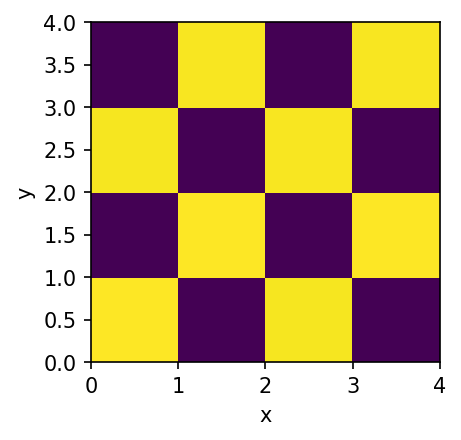

In [3]:
# Let's plot this distribution
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax.set(xlabel="x", ylabel="y")
plt.show()

In [5]:
# now let's build a normalizing flow like we usually would for continuous data

# scale data so its all in range (-5, 5)
means = 2
stds = 2/5

bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, B=5.1),
)

latent = Uniform((-5, 5), (-5, 5))

flow = Flow(data.columns, bijector, latent=latent)

In [6]:
%%time
opt = adam(step_size=1e-4)
losses = flow.train(data, optimizer=opt, verbose=True)

Training 50 epochs 
Loss:
3.6243
0.7013
-0.3636
0.3643
-0.8036
0.4569
-0.1392
0.4764
0.1337
-0.2762
-0.6269
0.8308
-0.2876
-0.5393
-0.9271
-1.2253
-0.8107
-1.0850
-1.3161
-0.9053
-0.8960
-1.2713
-1.2544
3.8095
-0.7850
-0.6952
CPU times: user 7min 49s, sys: 3min 29s, total: 11min 18s
Wall time: 1min 49s


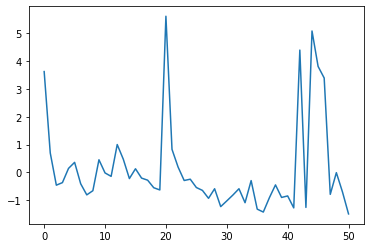

In [7]:
# we can see that the training was relatively unstable
plt.plot(losses)

In [ ]:
# we really should try adjusting the learning schedule to stabilize training
# but luckily the training ended on a lowpoint of the curve
# so let's go ahead and look at samples below

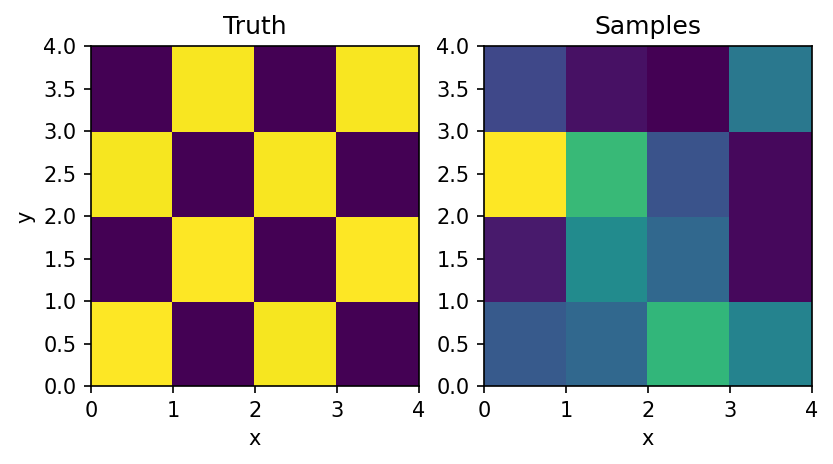

In [8]:
# and the samples don't look too good.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.2, 3), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(xlabel="x", ylabel="y", title="Truth")

samples = flow.sample(N)
ax2.hist2d(samples["x"], samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(xlabel="x", title="Samples")

plt.show()

In [9]:
# now let's add a dequantizer to the bijection
# this dequantizer adds uniform noise to the discrete inputs

@Bijector
def UniformDequantizer() -> Tuple[InitFunction, Bijector_Info]:
    
    bijector_info = ("Dequantizer", ())
    dq_dist = Uniform((0, 1))
    
    @InitFunction
    def init_fun(rng, input_dim, **kwargs):
        @ForwardFunction
        def forward_fun(params, inputs, **kwargs):
            u = dq_dist.sample((), inputs.shape[0], seed=None)
            outputs = inputs + u
            log_det = np.zeros(inputs.shape[0])
            return outputs, log_det

        @InverseFunction
        def inverse_fun(params, inputs, **kwargs):
            outputs = np.floor(inputs)
            log_det = np.zeros(inputs.shape[0])
            return outputs, log_det

        return (), forward_fun, inverse_fun

    return init_fun, bijector_info

In [14]:
# build the new flow with the uniform dequantizer

# scale data so its all in range (-5, 5)
means = 2
stds = 2/5

bijector = Chain(
    UniformDequantizer(),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, B=5.1),
)

latent = Uniform((-5, 5), (-5, 5))

udq_flow = Flow(data.columns, bijector, latent=latent)

In [15]:
%%time
opt = adam(step_size=1e-3)
udq_losses = udq_flow.train(data, epochs=100, optimizer=opt, verbose=True)

Training 100 epochs 
Loss:
3.7686
2.6396
1.5259
0.8751
1.0678
0.2301
0.0737
0.4646
1.7526
-0.4855
-1.0076
-0.5129
0.8402
-0.7953
8.1747
-0.8166
-1.0487
2.0847
-0.7994
-1.2234
-1.0423
CPU times: user 14min 34s, sys: 4min 37s, total: 19min 11s
Wall time: 3min 10s


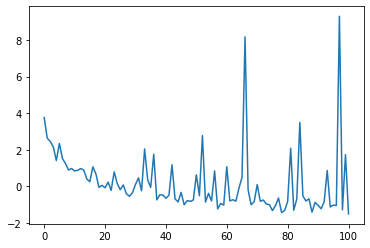

In [16]:
# again we can see that the training was pretty unstable
# should probably train with lr=1e-3 for 50 epochs
# and then switch to lr=1e-4 for the last 50
plt.plot(udq_losses)

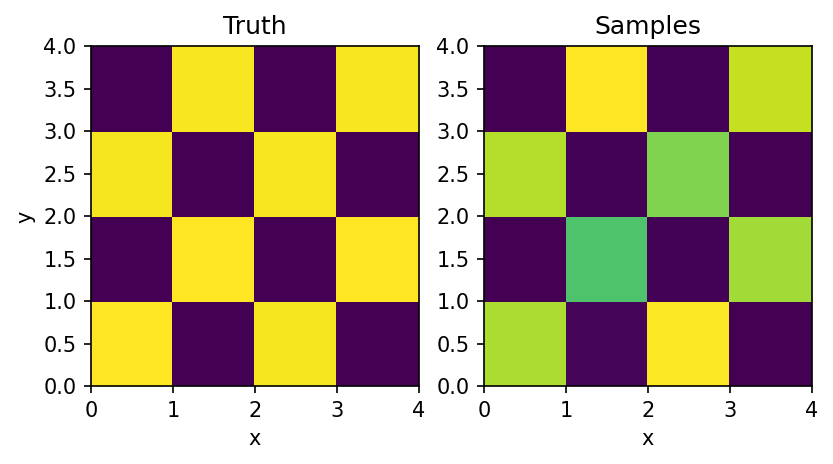

In [17]:
# the samples are looking pretty great though!
# note this is because luckily the training stopped on a low point of the training curve
# if it hadn't, we would need to retrain and adjust the lr schedule to try to stabilize the training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.2, 3), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(xlabel="x", ylabel="y", title="Truth")

udq_samples = udq_flow.sample(N)
ax2.hist2d(udq_samples["x"], udq_samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(xlabel="x", title="Samples")

plt.show()

Dequantization with uniform noise definitely improved the flow, but let's try to do even better using Bipartite Dequantization \[[Hoogeboom 2020](https://arxiv.org/abs/2001.11235)\]. This means we will learn the dequantization distribution via another normalizing flow! I will use Rolling Spline Couplings for this, and call this Rolling Spline Dequantization (RSD).

In [19]:
# now let's add a dequantizer to the bijection
# this dequantizer adds uniform noise to the discrete inputs

@Bijector
def RollingSplineDequantizer() -> Tuple[InitFunction, Bijector_Info]:
    
    bijector_info = ("Dequantizer", ())
    dq_dist = Uniform((-0.5, 0.5))
    
    @InitFunction
    def init_fun(rng, input_dim, **kwargs):
        
        RSC_init_fun, RSC_info = RollingSplineCoupling(nlayers=input_dim, B=0.5)
        RSC_params, RSC_fwd, RSC_inv = RSC_init_fun(rng, input_dim)
        
        @ForwardFunction
        def forward_fun(params, inputs, **kwargs):
            u = dq_dist.sample((), input_dim*inputs.shape[0], seed=None).reshape(inputs.shape[0], input_dim)
            u, _ = RSC_fwd(params, u, conditions=np.zeros((inputs.shape[0], 1)))
            outputs = inputs + u + 0.5
            log_det = np.zeros(inputs.shape[0])
            return outputs, log_det
            
        @InverseFunction
        def inverse_fun(params, inputs, **kwargs):
            outputs = np.floor(inputs)
            log_det = np.zeros(inputs.shape[0])
            return outputs, log_det

        return RSC_params, forward_fun, inverse_fun

    return init_fun, bijector_info

In [20]:
# build the new flow with the dequantizer

# scale data so its all in range (-5, 5)
means = 2
stds = 2/5

bijector = Chain(
    RollingSplineDequantizer(),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, B=5.1),
)

latent = Uniform((-5, 5), (-5, 5))

dq_flow = Flow(data.columns, bijector, latent=latent)

In [22]:
%%time
opt = adam(step_size=1e-4)
dq_losses = dq_flow.train(data, epochs=100, optimizer=opt, verbose=True)

Training 100 epochs 
Loss:
3.7948
3.5451
-0.5436
1.4599
-1.1855
-0.2273
-0.6895
2.3949
-1.2250
-1.1768
-1.8716
-2.4687
0.2156
-1.1269
-0.5409
-0.0237
0.0942
2.5990
1.0112
5.4389
4.0092
CPU times: user 28min 18s, sys: 8min 56s, total: 37min 15s
Wall time: 6min 6s


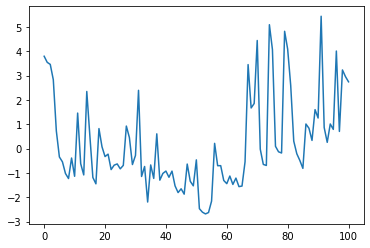

In [23]:
# we can see that the training was more stable
plt.plot(dq_losses)

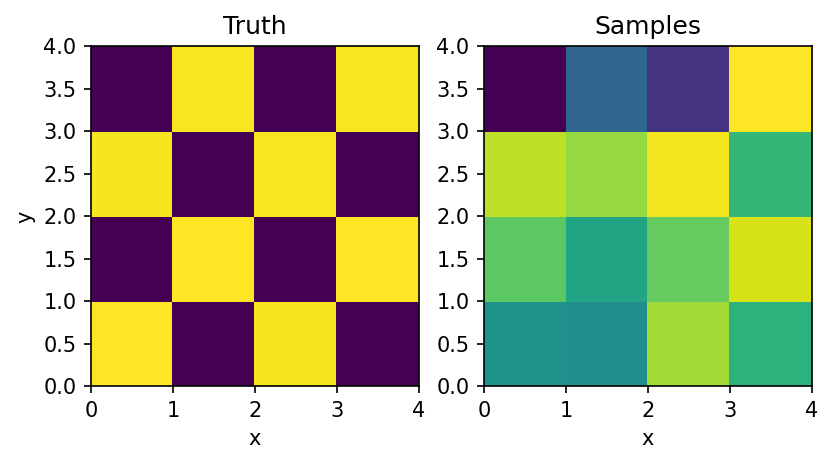

In [24]:
# and the samples are looking better
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.2, 3), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(xlabel="x", ylabel="y", title="Truth")

dq_samples = dq_flow.sample(N)
ax2.hist2d(dq_samples["x"], dq_samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(xlabel="x", title="Samples")

plt.show()